# Differential privacy for GDPR compliance

Differential privacy is still not widely known, also there is quite a bit discourse if it hold up to its promises at all. Since by now also Google and Apple claim to use differential privacy, I started investigating it by reading "the"
book on differential privacy by Cynthia Dwork. You can download for free here. 

I came along this topic while searching for method to gather business intelligence data in a GDPR conform way. General Data Protection Regulation  will be implemented on 2018-05-25 and is quite difficult to transfer into real world processes. It comes also with [hefty penalties](https://en.wikipedia.org/wiki/General_Data_Protection_Regulation#Sanctions), so that every company that processes personal data should take the time to check their data processing workflows.

I am assuming in my example (simplified) that there are two systems:

* one system that holds data bound to privacy constraints, but all access is restricted by passwords, encryption and similar, so that only the user it self can access his data. 
* one system that collects overall data needed for business development. This may be a huge database where all other systems (incl. the one system mentioned above) just sent their stats to and that generates the reports for business management.

The problem is the following: How can we make sure that no privacy concerns are violated when sending data to the central data pool system? Statistics can be simple ones as active users up to data that will be used for active learning in a machine learning based scenario. Even data that is not directly bound to persons can be used in combination with other (meta) data to deanonymize information. See these two examples.

Differential privacy makes this bold promise:

> Learn nothing about the individual, learn something about the population.


Let make a simple example:
We want to learn about a population how many people are Justin Bieber Fans - without knowing this excatly for one user to not violate the privay of that user. So we need to make sure, that we can not draw any conclusion in that central system once the data is sent. Normal "attack" or "exploit" vectors would be to ask the central database before and after data sending. By knowing the Bieber fans before and after that one users statistics were sent an attacker could learn if that persons is Bieber fans or not. Not good!

Let's improve. We need to add noise or fake data, so that we can not tell for sure what happens per user basis. Since our data in this simplified example is only binary, we add noise.

## Simple example

Let us put this into code and play a bit with that scenario. When sending one person's data into the data set, we add noise: 

* 50% of the time we tell the truth and 
* the other 50% of the time we do a coin flip and send that

First we are generating a data set, that represents the our real distribution. We model Heads as boolean True, Tails is False. Roughly 10% of the population in our simplified example are Justin Bieber fans ( $p = 0.1 $)



In [1]:
import numpy as np

def generate_population(size, probability):
    return np.random.choice([True, False], size, p=[probability, 1-probability])


population = generate_population(1000, 0.1)

In a real world scenario we do not know the probabilities here. We will later calcuate those values with the information we learn.

Let us create a function that represents adding the noise while sending out collected to the data pool.


In [2]:
from random import random


fuzz = lambda x: x if random() > 0.5 else random() > 0.5

Now we are evaluating our data after we send it through the fuzzer. 


In [3]:
after_noise_population = [fuzz(i) for i in population]

bieber_fans_count_after_noise = np.sum(after_noise_population)
bieber_fans_count_before_noise = np.sum(population)
print(f"In our population {bieber_fans_count_before_noise} are Justin Bieber fans.")
print(f"In the central system, after adding noise we have {bieber_fans_count_after_noise} Justin Bieber fans.")

In our population 96 are Justin Bieber fans.
In the central system, after adding noise we have 292 Justin Bieber fans.


Let now see how we can derive the distribution of Justin Bieber fans in the real popluation from our central database. The number above, Bieber fans after adding noise, consist of those actual bieber fans if the first coin flip is Heads and the ones where the first coin flip was Tails, but the second coin flip Heads. So with the fraction of bieber fans as $f_{JB}$:


$$ 
\begin{aligned}
f_{JB} &= \frac{1}{2}p + \frac{1}{4} \\
p &= 2(f_{JB} - \frac{1}{4})
\end{aligned}
$$

Note, that in our little example we know the real probability, since we set it initially to 0.1. Transferring this example to a real world, we would not know this, but need to derive it as shown above.

Let's see how many data we need to get to a staple value. For that we plot our findings over growing population sizes.

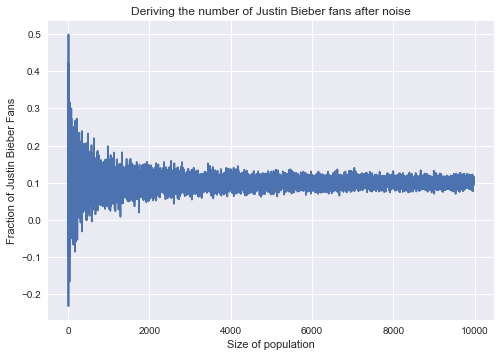

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

def compute(size, p):
    population = generate_population(size, p)
    w_noise = [fuzz(i) for i in population]
    ratio = np.sum(w_noise) / size
    
    real_p = 2*(ratio-0.25)
    return real_p

sim_sizes = [compute(i, 0.1) for i in range(10, 10000)]

plt.plot(sim_sizes)
plt.ylabel('Fraction of Justin Bieber Fans')
plt.xlabel('Size of population')
plt.title('Deriving the number of Justin Bieber fans after noise');

Here we see that our probabily stabilizes around 0.1 with a growing population size.

## Conclusions

We transferred binary data differentially private. This is just a small step, using the same technique for vectors of information in way to retrieve usable data in the end is way harder. I hope to show some more complex example in later articles. 

Also, differential privacy seems to gain traction very slowly. In my opinion the main problem here is to prove how private the data is afterwards. That is very abstract, hence my attempt to put all this in a simple understandable code example.